<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap.min.css">

<div class='text-center text-danger bg-warning container'><h1>Designing Winning Strategy for a Soccer Team - Atletico Madrid</h1></div>
<div class='text-center text-danger bg-warning container'><h6><u>03 Oct 2018</u></h6></div>
<div class='text-center text-danger bg-warning container'>&#160;</div>


<h4> Table of contents </h4>
<ol>
    <li>Data cleaning and preparation</li>
    <li>Approach 1: Identification of winning strategy across all the games</li>
    <li>Approach 2: Atletico Madrid team leading to a victory</li>
    <li>Approach 3: How to be player independent - Atrribute analysis</li>
    <li>Approach 4: Understanding opponants</li>
    <li>Approach 5: Event analysis for live decision making</li>
    <li>Conclusions & Recommendations</li>
</ol>

### Load Dependencies

In [49]:
# Load required data and packages
options(warn=-1)
library(plyr)
library(dplyr)
library(magrittr)
library(stringr)
library(dbplyr)
library(RSQLite)
library(tidyr)
library(data.table)
library(arules)
library(arulesViz)
library(tidyr)
library(lubridate)
library(ggplot2)

setwd('C:\\Users\\himan\\Desktop\\Notebooks')

con <- src_sqlite("euro_soccer.sqlite")
country_tbl <- tbl(con, "country")  %>%  collect()
league_tbl <- tbl(con, "league")  %>%  collect()
match_tbl <- tbl(con, "match")  %>%  collect()
player_tbl <- tbl(con, "player")  %>%  collect()
player_atts_tbl <- tbl(con, "player_attributes")  %>%  collect()
team_tbl <- tbl(con, "team")  %>%  collect()
team_atts_tbl <- tbl(con, "team_attributes")  %>%  collect()


<hr>
<h2>Approach 1: Identification of winning strategy across all the games</h2>
<h4><i>Explanation:</i></h4>

Regardless of the team we are doing the analysis for, it is important to understand which factors lead to a win in general. The basic rationale behind this approach is to identify common team traits across all games that lead to a win. By knowing these traits, the team's strategy can be altered to improve the chance of winning.

<h4><i>Key Goal:</i></h4>

Identification of patterns across all the games leading to a win


### Transforming & Cleaning Data

There are 11 leagues in the datset, however the leagues are not all of the same quality. These leagues were first filtered to only include La Liga, English Premier League, Ligue 1, Bundesliga, and Serie A. These leagues were selected as they each included at least 3 teams in the top 50 of FiveThirtyEight's club rankings (https://projects.fivethirtyeight.com/global-club-soccer-rankings/). The results of analysing on this section of the data will be more relevant to Atletico Madrid.

In [50]:
all_league_ids <- c(21518, 1729, 4769, 7809, 10257)
# select relevant league
match_tbl <- match_tbl %>% filter(league_id %in% all_league_ids)

There are 10 odds sources for each match. This next step aggregates all of the odds into one statistics for Home Win, Away Win, and Draw.

In [51]:
# aggregate the odds
match_tbl$H_ODDS <- rowMeans(match_tbl[,c(86,89,92,95,98,101,104,107,110,113)], na.rm = TRUE)
match_tbl$D_ODDS <- rowMeans(match_tbl[,c(87,90,93,96,99,102,105,108,111,114)], na.rm = TRUE)
match_tbl$A_ODDS <- rowMeans(match_tbl[,c(88,91,94,97,100,103,106,109,112,115)], na.rm = TRUE)

# remove irrelevant columns
match_tbl <- match_tbl[,-c(78:115)]
match_tbl <- match_tbl[, -c(1:5)]
match_tbl <- match_tbl[, -c(7:72)]

The match_tbl contains goal data for the home and away team, however it does not contain a column for which team won or if it was a draw. The next step first creates a column that specifies if the home team won, if the away team won, or if the match was a draw, and then a second column was created that flags that match as an underdog win, an expected win, or a draw.

In [52]:
# win/loss/draw
match_tbl <- match_tbl %>% 
  mutate(H_WIN = ifelse(home_team_goal > away_team_goal, 1, 0)) %>%
  mutate(A_WIN = ifelse(home_team_goal < away_team_goal, 1, 0)) %>%
  mutate(DRAW = ifelse(home_team_goal == away_team_goal, 1, 0)) %>%
  mutate(H_WIN = as.factor(H_WIN)) %>%
  mutate(A_WIN = as.factor(A_WIN)) %>%
  mutate(DRAW = as.factor(DRAW))

# underdog wins
match_tbl <- match_tbl %>%
  mutate(UNDER_WIN = if_else((H_WIN == 1 & H_ODDS > A_ODDS) | (A_WIN == 1 & H_ODDS < A_ODDS), "UNDER_WIN",
                             if_else(DRAW == 1, "DRAW","EXPECTED_WIN"))) %>%
  mutate(UNDER_WIN = as.factor(UNDER_WIN))

The next step is to prepare the match_tbl data to be joined with the team_atts_tbl. These two tbls will be joined on the team api id and the year as there are multiple years of data in the dataset. The first code chunk will join the two tbls with a win or loss as the result, while the second code chunk will join the two tbls with a expected wins or underdog wins as the result..

In [53]:
# get wining ids and years
win_ids <- c(match_tbl$home_team_api_id[match_tbl$H_WIN == "1"],
             match_tbl$away_team_api_id[match_tbl$A_WIN == "1"])
win_ids_year <- c(year(match_tbl$date[match_tbl$H_WIN == "1"]),
                  year(match_tbl$date[match_tbl$A_WIN == "1"]))

# get losing ids and years
lose_ids <- c(match_tbl$home_team_api_id[match_tbl$A_WIN == "1"],
              match_tbl$away_team_api_id[match_tbl$H_WIN == "1"])
lose_ids_year <- c(year(match_tbl$date[match_tbl$A_WIN == "1"]),
                   year(match_tbl$date[match_tbl$H_WIN == "1"]))

# combining the winning and losing ids and years into two columns
result_ids <- c(win_ids, lose_ids)
result_years <- c(win_ids_year, lose_ids_year)

# create a column of result flags
win <- rep("W", 10846)
lose <- rep("L", 10846)
WL <- c(win, lose)

# turn the id, year, and flag columns into a tbl
results_tbl <- as_tibble(result_ids)
results_tbl$year <- result_years
results_tbl$result <- WL
colnames(results_tbl) <- c("api_id", "year", "result")

# create a year column from the date column to be able to join
team_atts_tbl <- team_atts_tbl %>% mutate(yr = year(date))

# join the columns on api_id and year
result_tbl_atts <- inner_join(results_tbl,
                              team_atts_tbl,
                              by=c("api_id"="team_api_id","year"="yr"))

# select the attributes in a "transaction"
win_loss_rules_tbl <- result_tbl_atts %>%
  select(result, buildUpPlaySpeedClass, buildUpPlayDribblingClass, buildUpPlayPassingClass, buildUpPlayPositioningClass,
         chanceCreationPassingClass, chanceCreationCrossingClass, chanceCreationPositioningClass, defencePressureClass,
         defenceAggressionClass, defenceTeamWidthClass, defenceDefenderLineClass)

# Make values unique to column
win_loss_rules_tbl$buildUpPlaySpeedClass <- paste("buildUpPlaySpeedClass",
                                                 win_loss_rules_tbl$buildUpPlaySpeedClass,
                                                 sep="_")
win_loss_rules_tbl$buildUpPlayDribblingClass <- paste("buildUpPlayDribblingClass",
                                                     win_loss_rules_tbl$buildUpPlayDribblingClass,
                                                     sep="_")
win_loss_rules_tbl$buildUpPlayPassingClass <- paste("buildUpPlayPassingClass",
                                                   win_loss_rules_tbl$buildUpPlayPassingClass,
                                                   sep="_")
win_loss_rules_tbl$buildUpPlayPositioningClass <- paste("buildUpPlayPositioningClass",
                                                       win_loss_rules_tbl$buildUpPlayPositioningClass,
                                                       sep="_")
win_loss_rules_tbl$chanceCreationPassingClass <- paste("chanceCreationPassingClass",
                                                      win_loss_rules_tbl$chanceCreationPassingClass,
                                                      sep="_")
win_loss_rules_tbl$chanceCreationCrossingClass <- paste("chanceCreationCrossingClass",
                                                       win_loss_rules_tbl$chanceCreationCrossingClass,
                                                       sep="_")
win_loss_rules_tbl$chanceCreationPositioningClass <- paste("chanceCreationPositioningClass",
                                                          win_loss_rules_tbl$chanceCreationPositioningClass,
                                                          sep="_")
win_loss_rules_tbl$defencePressureClass <- paste("defencePressureClass",
                                                win_loss_rules_tbl$defencePressureClass,
                                                sep="_")
win_loss_rules_tbl$defenceAggressionClass <- paste("defenceAggressionClass",
                                                  win_loss_rules_tbl$defenceAggressionClass,
                                                  sep="_")
win_loss_rules_tbl$defenceTeamWidthClass <- paste("defenceTeamWidthClass",
                                                 win_loss_rules_tbl$defenceTeamWidthClass,
                                                 sep="_")
win_loss_rules_tbl$defenceDefenderLineClass <- paste("defenceDefenderLineClass",
                                                    win_loss_rules_tbl$defenceDefenderLineClass,
                                                    sep="_")

In [54]:
# get underdog winning ids and years
u_win_ids <- c(match_tbl$home_team_api_id[match_tbl$UNDER_WIN == "UNDER_WIN"],
             match_tbl$away_team_api_id[match_tbl$A_WIN == "UNDER_WIN"])

u_win_ids_year <- c(year(match_tbl$date[match_tbl$UNDER_WIN == "UNDER_WIN"]))

# get expected win ids and years
e_win_ids <- c(match_tbl$home_team_api_id[match_tbl$UNDER_WIN == "EXPECTED_WIN"],
                 match_tbl$away_team_api_id[match_tbl$A_WIN == "EXPECTED_WIN"])

e_win_ids_year <- c(year(match_tbl$date[match_tbl$UNDER_WIN == "EXPECTED_WIN"]))

# combine into one column
result_ids <- c(u_win_ids, e_win_ids)
result_years <- c(u_win_ids_year, e_win_ids_year)

# create flag column
u_win <- rep("UNDERDOG_WIN", 3124)
e_win <- rep("EXPECTED_WIN", 7729)
res <- c(u_win, e_win)

# combine all data into a tbl
results_tbl <- as_tibble(result_ids)
results_tbl$year <- result_years
results_tbl$result <- res
colnames(results_tbl) <- c("api_id", "year", "result")

# join with team attributes
result_tbl_atts <- inner_join(results_tbl, team_atts_tbl, by=c("api_id"="team_api_id","year"="yr"))

# select attributes in a "transaction"
underdog_rules_tbl <- result_tbl_atts %>%
  select(result, buildUpPlaySpeedClass, buildUpPlayDribblingClass, buildUpPlayPassingClass, buildUpPlayPositioningClass,
         chanceCreationPassingClass, chanceCreationCrossingClass, chanceCreationPositioningClass, defencePressureClass,
         defenceAggressionClass, defenceTeamWidthClass, defenceDefenderLineClass)

# Make values unique to column
underdog_rules_tbl$buildUpPlaySpeedClass <- paste("buildUpPlaySpeedClass",
                                                 underdog_rules_tbl$buildUpPlaySpeedClass,
                                                 sep="_")
underdog_rules_tbl$buildUpPlayDribblingClass <- paste("buildUpPlayDribblingClass",
                                                     underdog_rules_tbl$buildUpPlayDribblingClass,
                                                     sep="_")
underdog_rules_tbl$buildUpPlayPassingClass <- paste("buildUpPlayPassingClass",
                                                   underdog_rules_tbl$buildUpPlayPassingClass,
                                                   sep="_")
underdog_rules_tbl$buildUpPlayPositioningClass <- paste("buildUpPlayPositioningClass",
                                                       underdog_rules_tbl$buildUpPlayPositioningClass,
                                                       sep="_")
underdog_rules_tbl$chanceCreationPassingClass <- paste("chanceCreationPassingClass",
                                                      underdog_rules_tbl$chanceCreationPassingClass,
                                                      sep="_")
underdog_rules_tbl$chanceCreationCrossingClass <- paste("chanceCreationCrossingClass",
                                                       underdog_rules_tbl$chanceCreationCrossingClass,
                                                       sep="_")
underdog_rules_tbl$chanceCreationPositioningClass <- paste("chanceCreationPositioningClass",
                                                          underdog_rules_tbl$chanceCreationPositioningClass,
                                                          sep="_")
underdog_rules_tbl$defencePressureClass <- paste("defencePressureClass",
                                                underdog_rules_tbl$defencePressureClass,
                                                sep="_")
underdog_rules_tbl$defenceAggressionClass <- paste("defenceAggressionClass",
                                                  underdog_rules_tbl$defenceAggressionClass,
                                                  sep="_")
underdog_rules_tbl$defenceTeamWidthClass <- paste("defenceTeamWidthClass",
                                                 underdog_rules_tbl$defenceTeamWidthClass,
                                                 sep="_")
underdog_rules_tbl$defenceDefenderLineClass <- paste("defenceDefenderLineClass",
                                                    underdog_rules_tbl$defenceDefenderLineClass,
                                                    sep="_")

Now we will output each tbl to a csv in order to read back in as transactions, in order to develop association rules.

In [55]:
# win loss transaction
write.csv(win_loss_rules_tbl, "team_results_all_leagues.csv", row.names = FALSE)
rule_data_winloss <- read.transactions("team_results_all_leagues.csv",format=c("basket"),sep=",")

# underdog transaction
write.csv(underdog_rules_tbl, "underdog_results_all_leagues.csv", row.names = FALSE)
rule_data_under <- read.transactions("underdog_results_all_leagues.csv",format=c("basket"),sep=",")

### Association Rules for Wins

The first rules were developed to see which single attributes co-occur with wins. The output is sorted by lift, but sorting by confidence will yield the same result.

In [56]:
rules <- apriori(rule_data_winloss,
                 parameter=list(supp = 0.01, conf=0.5, maxlen=2),
                 appearance = list(rhs=c("W","L")))

rules <- sort(rules,by="lift",decreasing=TRUE)
inspect(rules[1:10])

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5    0.01      1
 maxlen target   ext
      2  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 162 

set item appearances ...[2 item(s)] done [0.00s].
set transactions ...[44 item(s), 16261 transaction(s)] done [0.01s].
sorting and recoding items ... [32 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 done [0.00s].
writing ... [338 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
     lhs                                        rhs                                           support confidence     lift
[1]  {defencePressureClass_High}             => {defenceTeamWidthClass_Wide}               0.03474571  0.6873479 8.597665
[2]  {defenceTeamWidthClass_Narrow}        

#### Interpretation

This simple set of rules gives some initial ideas on which traits are important. If these traits continue to appear in more sophisticated rules, then they can be seen as traits that winning teams embody.

The next rules were developed to see which pairs of attributes co-occur with wins. 

In [57]:
rules <- apriori(rule_data_winloss,
                 parameter=list(supp = 0.01, conf=0.5, maxlen=3),
                 appearance = list(rhs=c("W","L")))

rules <- sort(rules,by="lift",decreasing=TRUE)
inspect(rules[1:10])

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5    0.01      1
 maxlen target   ext
      3  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 162 

set item appearances ...[2 item(s)] done [0.00s].
set transactions ...[44 item(s), 16261 transaction(s)] done [0.00s].
sorting and recoding items ... [32 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [3258 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
     lhs                                           rhs                                        support confidence     lift
[1]  {defenceAggressionClass_Double,                                                                                     
      defenceTeamWidthClass_Wide}       

#### Interpretation

This next set of rules gives more weight to the traits that appeared in the simple set of rules. 

The traits:
* chanceCreationPositioningClass_Free Form
* chanceCreationCrossingClass_Little
* buildUpPlayPositioningClass_Free Form
* buildUpPlayPassingClass_Short

are starting to stick out as important.

Finally, association rules were formed which allow for every team trait to be included in the rule

In [58]:
rules <- apriori(rule_data_winloss,
                 parameter=list(supp = 0.01, conf=0.5, maxlen=12),
                 appearance = list(rhs=c("W","L")))

rules <- sort(rules,by="lift",decreasing=TRUE)
inspect(rules[1:10])

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5    0.01      1
 maxlen target   ext
     12  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 162 

set item appearances ...[2 item(s)] done [0.00s].
set transactions ...[44 item(s), 16261 transaction(s)] done [0.01s].
sorting and recoding items ... [32 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 5 6 7 8 9 10 11 12 done [0.03s].
writing ... [129907 rule(s)] done [0.03s].
creating S4 object  ... done [0.04s].
     lhs                                           rhs                                 support confidence     lift
[1]  {buildUpPlayPassingClass_Short,                                                                              
      chanceCreationPassingClas

#### Interpretation
This final set of rules gives a robust view of the traits that winning teams typically posess.

The traits:
* buildUpPlayPassingClass_Short
* buildUpPlayPositioningClass_Free Form
* chanceCreationPositioningClass_Free Form
* chanceCreationCrossingClass_Little
* defenceAggressionClass_Press
* defencePressureClass_Medium
* defenceTeamWidthClass_Normal

are the ones which winning teams typically possess.

### Association Rules for Underdog Wins

The same strategy was used for underdog wins, where first single attributes were viewed, then pairs, and then all attributes

In [59]:
rules <- apriori(rule_data_under,
                 parameter=list(supp = 0.05, conf=0.2, maxlen=2),
                 appearance = list(rhs=c("UNDERDOG_WIN")))

rules <- sort(rules,by="lift",decreasing=TRUE)
inspect(rules[1:10])

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.2    0.1    1 none FALSE            TRUE       5    0.05      1
 maxlen target   ext
      2  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 406 

set item appearances ...[1 item(s)] done [0.00s].
set transactions ...[44 item(s), 8126 transaction(s)] done [0.00s].
sorting and recoding items ... [26 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 done [0.00s].
writing ... [296 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
     lhs                                           rhs                                           support confidence     lift
[1]  {chanceCreationPositioningClass_Free Form} => {buildUpPlayPositioningClass_Free Form}    0.06473049  0.3483444 3.970051
[2]  {buildUpPlayPositioningClass_Free

In [60]:
rules <- apriori(rule_data_under,
                 parameter=list(supp = 0.05, conf=0.3, maxlen=3),
                 appearance = list(rhs=c("UNDERDOG_WIN")))

rules <- sort(rules,by="lift",decreasing=TRUE)
inspect(rules[1:10])

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.3    0.1    1 none FALSE            TRUE       5    0.05      1
 maxlen target   ext
      3  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 406 

set item appearances ...[1 item(s)] done [0.00s].
set transactions ...[44 item(s), 8126 transaction(s)] done [0.00s].
sorting and recoding items ... [26 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [1815 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
     lhs                                           rhs                                           support confidence     lift
[1]  {chanceCreationPositioningClass_Free Form,                                                                             
      EXPECTED_WIN}                

In [61]:
rules <- apriori(rule_data_under,
                 parameter=list(supp = 0.05, conf=0.32, maxlen=12),
                 appearance = list(rhs=c("UNDERDOG_WIN")))

rules <- sort(rules,by="lift",decreasing=TRUE)
inspect(rules[1:10])

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
       0.32    0.1    1 none FALSE            TRUE       5    0.05      1
 maxlen target   ext
     12  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 406 

set item appearances ...[1 item(s)] done [0.00s].
set transactions ...[44 item(s), 8126 transaction(s)] done [0.00s].
sorting and recoding items ... [26 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 5 6 7 8 9 10 11 12 done [0.01s].
writing ... [49930 rule(s)] done [0.01s].
creating S4 object  ... done [0.02s].
     lhs                                           rhs                                           support confidence     lift
[1]  {chanceCreationPositioningClass_Free Form,                                                                             
      EXPECTE

#### Interpretation
This final set of rules gives a robust view of the traits that underdog teams who win typically posess.

The traits:
* buildUpPlayDribblingClass_Normal
* buildUpPlayPassingClass_Mixed
* buildUpPlaySpeedClass_Balanced
* buildUpPlayPositioningClass_Organised
* chanceCreationCrossingClass_Normal
* chanceCreationPositioningClass_Organised
* defenceAggressionClass_Press
* defenceDefenderLineClass_Cover
* defenceTeamWidthClass_Normal

are the ones which winning underdog teams typically possess.

#### Conclusion from approach 1

Association rules reveal team traits which co-occur with winning. There are some trait categories that do not show up in the rules and can be kept the same as what the team currently uses. As an overall strategy, Atletico Madrid should align their team strategy with the set of traits developed from win/loss rules. These traits are:
* buildUpPlayPassingClass_Short
* buildUpPlayPositioningClass_Free Form
* chanceCreationPositioningClass_Free Form
* chanceCreationCrossingClass_Little
* defenceAggressionClass_Press
* defencePressureClass_Medium
* defenceTeamWidthClass_Normal

This strategy will be effective for most games, but when Atletico Madrid is predicted as the underdog in a matchup, they should alter their strategy of these traits: 
* buildUpPlayDribblingClass_Normal
* buildUpPlayPassingClass_Mixed
* buildUpPlaySpeedClass_Balanced
* buildUpPlayPositioningClass_Organised
* chanceCreationCrossingClass_Normal
* chanceCreationPositioningClass_Organised
* defenceDefenderLineClass_Cover

<h4><i>Potential drawbacks</i></h4>
* The ability to employ these strategies depends on the personnel of the team. For example, using a Positioning Class of Free Form means that players are allowed more flexibility. With an inexperienced team this may result in players being out of position.

<h4><i>Based on conclusions from Approach 1, explanation of Approach and Goals 2</i></h4>
Now that we have identified overall team attributes, we would like to identify patterns for our team that have led us to a positive / winning performance. These patterns will help maintain the team's current advantages.

<hr>
<h2>Approach 2: Atletico Madrid team leading to a victory</h2>
<h4><i>Explanation</i></h4>

It is imperative to identify unique strengths of our team and combinations of players that have led us to victory. This will help us in deciding strategy for the team composition and incentivising well performing players.

<b>Key goal:</b>

Identify `team composition` beneficial for `Atletico Madrid`


In [62]:

#Converting into data frame

match_tbl <- tbl(con, "match")  %>%  collect()
league <- data.frame(league_tbl)  # 11 leagues in total
country <- data.frame(country_tbl) # country corresponding to leagues- 11
match <- data.frame(match_tbl)
player <- data.frame(player_tbl)
player_atts <- data.frame(player_atts_tbl)
team <- data.frame(team_tbl)
team_atts <- data.frame(team_atts_tbl) # Team attributes for years 2010-2015


## Filtering all tables for our team 
long_team_name <- 'Atl?tico Madrid'
relevant_api_id <- 9906
relevant_league_id <- 21518

#Filtering ROMA Matches for home games and away games
r_match_home <- match %>% filter(home_team_api_id == 9906 ) %>% mutate(goal_diff = home_team_goal - away_team_goal) 
r_match_away <- match %>% filter(away_team_api_id == 9906) %>% mutate(goal_diff =home_team_goal - away_team_goal) 

# Home and Away wins
r_matchH_wins <- r_match_home %>% filter(goal_diff>0) %>% select(1:11,goal_diff,home_player_1 : home_player_11) %>% gather(player_no, player_id, -c(1:12)) %>% mutate ( win = "W") 

r_matchA_wins <- r_match_away %>% filter(goal_diff<0)%>% select(1:11,goal_diff,away_player_1 : away_player_11)%>% gather(player_no, player_id, -(1:12)) %>% mutate ( win = "W")

# Home and Away losses
r_matchH_loss <- r_match_home %>% filter(goal_diff<0)%>% select(1:11,goal_diff,home_player_1 : home_player_11)%>% gather(player_no, player_id, -(1:12)) %>% mutate ( win = "L")
r_matchA_loss <- r_match_away %>% filter(goal_diff>0)%>% select(1:11,goal_diff,away_player_1 : away_player_11)%>% gather(player_no, player_id, -(1:12)) %>% mutate ( win = "L")

# Home and Away Draws
r_matchH_draws <- r_match_home %>% filter(goal_diff==0)%>% select(1:11,goal_diff,home_player_1 : home_player_11)%>% gather(player_no, player_id, -(1:12)) %>% mutate ( win = "D")
r_matchA_draws <- r_match_away %>% filter(goal_diff==0)%>% select(1:11,goal_diff,away_player_1 : away_player_11)%>% gather(player_no, player_id, -(1:12)) %>% mutate ( win = "D")

# All winning/loss/draw matches
r_win <- rbind(r_matchH_wins,r_matchA_wins)
r_loss <- rbind(r_matchH_loss,r_matchA_loss)
r_draws <- rbind(r_matchH_draws,r_matchA_draws)

# All home/Away matches
r_home <- rbind(r_matchH_wins,r_matchH_loss,r_matchH_draws)
r_away <- rbind(r_matchA_wins,r_matchA_loss,r_matchA_draws)


#Market Basket Analysis 
#Apriori to find out the player combination that ensures wins/losses
r_comb <- rbind(r_win,r_loss,r_draws)
r_all <- r_comb %>% select(match_api_id,player_id )
r_all$player_id = as.character(r_all$player_id )
r_a2 <- r_comb[c("match_api_id","player_id")] 
r_a3 <- r_comb[c("match_api_id","win")]
# Renaming win column to player id so that we can append the above two tables
r_a3 = rename(r_a3,match_api_id=match_api_id,player_id=win)
r_all2 <-  rbind(r_a2,r_a3) %>% select(match_api_id,player_id )
r_all2$player_id = as.character(r_all2$player_id )
r_all2 = r_all2[!duplicated(r_all2),]

## Getting player names

r_final <- merge(r_all2, player[, c("player_api_id","player_name")],type ="inner" ,by.x ="player_id", by.y ="player_api_id")
r_final <- r_final %>% select(match_api_id,player_name )
r_a3 = rename(r_a3,match_api_id=match_api_id,player_name=player_id)
r_final <- rbind(r_final,r_a3) 

#Converting data into transaction format for MBA
trans22 <- as(split(r_final[,"player_name"], r_final[,"match_api_id"]), "transactions")
rules22 <- apriori(trans22,parameter=list(supp = 0.02, conf=0.6, maxlen=4), appearance = list(rhs=c("L","W","D")))

# Top 10 Rules for win
print("Top 10 Rules for Win")
print(" ")
rules_win2<- sort(rules22,by="lift",decreasing=TRUE)%>%
  subset(subset = (rhs %pin% "W"))
inspect(rules_win2[1:10])




Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.6    0.1    1 none FALSE            TRUE       5    0.02      1
 maxlen target   ext
      4  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 6 

set item appearances ...[3 item(s)] done [0.00s].
set transactions ...[87 item(s), 304 transaction(s)] done [0.00s].
sorting and recoding items ... [67 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [15300 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
[1] "Top 10 Rules for Win"
[1] " "
     lhs                            rhs    support confidence     lift
[1]  {Gabi,                                                           
      Lucas Hernandez}           => {W} 0.02302632          1 1.820359
[2]  {Fernando Torres,               

In [63]:
# Top 10 Rules for loss
print("Top 10 Rules for Loss")
print(" ")
rules_loss2<- sort(rules22,by="lift",decreasing=TRUE)%>%
  subset(subset = (rhs %pin% "L"))
inspect(rules_loss2[1:10 ])

[1] "Top 10 Rules for Loss"
[1] " "
     lhs                  rhs                  support confidence lift
[1]  {Mariano Pernia,                                                 
      Pablo Ibanez}    => {Leonardo Franco} 0.03289474          1  9.5
[2]  {Johnny Heitinga,                                                
      Pablo Ibanez}    => {Leonardo Franco} 0.02960526          1  9.5
[3]  {Diego Forlan,                                                   
      Luis Perea,                                                     
      Maniche}         => {Leonardo Franco} 0.02302632          1  9.5
[4]  {Mariano Pernia,                                                 
      Pablo Ibanez,                                                   
      Simao}           => {Leonardo Franco} 0.02631579          1  9.5
[5]  {Diego Forlan,                                                   
      Mariano Pernia,                                                 
      Pablo Ibanez}    => {Leonardo Franc

In [64]:
#### Player Locations for wins and loss

## Home Match wins + Loss
r_matchH<- rbind(r_matchH_wins,r_matchH_loss,r_matchH_draws) %>% mutate(player_no2 = substr(player_no,13,14))

r_matchH_locX <-  r_match_home %>% select(1:11,goal_diff,home_player_X1 : home_player_X11) %>% gather(player_no, x_loc, -c(1:12)) %>% mutate(player_no2 = substr(player_no,14,15))%>% select(match_api_id, player_no2, x_loc)

r_matchH_locY <-  r_match_home  %>% select(1:11,goal_diff,home_player_Y1 : home_player_Y11) %>% gather(player_no, y_loc, -c(1:12))%>% mutate(player_no2 = substr(player_no,14,15))%>% select(match_api_id, player_no2, y_loc)

r_matchH<- merge(r_matchH,r_matchH_locX, by = c("match_api_id"="match_api_id","player_no2" = "player_no2"))
r_matchH_final <- merge(r_matchH,r_matchH_locY, by = c("match_api_id"="match_api_id","player_no2" = "player_no2"))

## Away Match wins + Loss
r_matchA<- rbind(r_matchA_wins,r_matchA_loss,r_matchA_draws)  %>% mutate(player_no2 = substr(player_no,13,14))

r_matchA_locX <-  r_match_away  %>% select(1:11,goal_diff,away_player_X1 : away_player_X11) %>% gather(player_no, x_loc, -c(1:12)) %>% mutate(player_no2 = substr(player_no,14,15))%>% select(match_api_id, player_no2, x_loc)

r_matchA_locY <-  r_match_away  %>% select(1:11,goal_diff,away_player_Y1 : away_player_Y11) %>% gather(player_no, y_loc, -c(1:12))%>% mutate(player_no2 = substr(player_no,14,15))%>% select(match_api_id, player_no2, y_loc)

r_matchA<- merge(r_matchA,r_matchA_locX, by = c("match_api_id"="match_api_id","player_no2" = "player_no2"))
r_matchA_final <- merge(r_matchA,r_matchA_locY, by = c("match_api_id"="match_api_id","player_no2" = "player_no2"))
r_merge_loc <- rbind(r_matchH_final,r_matchA_final) %>% mutate(loc = paste(player_id,x_loc,y_loc,sep = "_"))


#Apriori to find out the player-location combination that ensures wins

r_o <- r_merge_loc %>% select(match_api_id,loc )
r_w <- r_merge_loc %>% select(match_api_id,win )
r_w = rename(r_w,match_api_id=match_api_id,loc=win)

r_all <- rbind(r_o,r_w)
x <- r_merge_loc %>% select(player_id, x_loc,y_loc) %>% group_by(player_id)  # To see if players have multiple locations
loc <- read.csv('loc.csv')
##########################
# To get Player names ###

r_final_merge <- merge(r_merge_loc, player[, c("player_api_id","player_name")],type ="inner" ,by.x ="player_id", by.y ="player_api_id") 
r_final_merge <- r_final_merge  %>% mutate(loc = paste(player_name,x_loc,y_loc,sep ="_")) %>% select(match_api_id,loc )
r_w <- r_merge_loc %>% select(match_api_id,win )
r_w = rename(r_w,match_api_id=match_api_id,loc=win)
r_final_merge <- rbind(r_final_merge,r_w)
trans32 <- as(split(r_final_merge[,"loc"], r_final_merge[,"match_api_id"]), "transactions")
rules32 <- apriori(trans32,parameter=list(supp = 0.05, conf=0.6, maxlen=4), appearance = list(rhs=c("L","W","D")))
rules_win3<- sort(rules32,by="lift",decreasing=TRUE)%>%
  subset(subset = (rhs %pin% "W"))
print("Top 10 Player-Position Rules for Win")
print(" ")
inspect(rules_win3[1:10])


Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.6    0.1    1 none FALSE            TRUE       5    0.05      1
 maxlen target   ext
      4  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 15 

set item appearances ...[3 item(s)] done [0.00s].
set transactions ...[360 item(s), 304 transaction(s)] done [0.00s].
sorting and recoding items ... [58 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [835 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
[1] "Top 10 Player-Position Rules for Win"
[1] " "
     lhs                                                rhs support   
[1]  {Filipe Luis_8_3,Juanfran_2_3,Koke_8_7}         => {W} 0.06250000
[2]  {Filipe Luis_8_3,Koke_8_7}                      => {W} 0.06578947
[3]  {Diego Godin_6_3

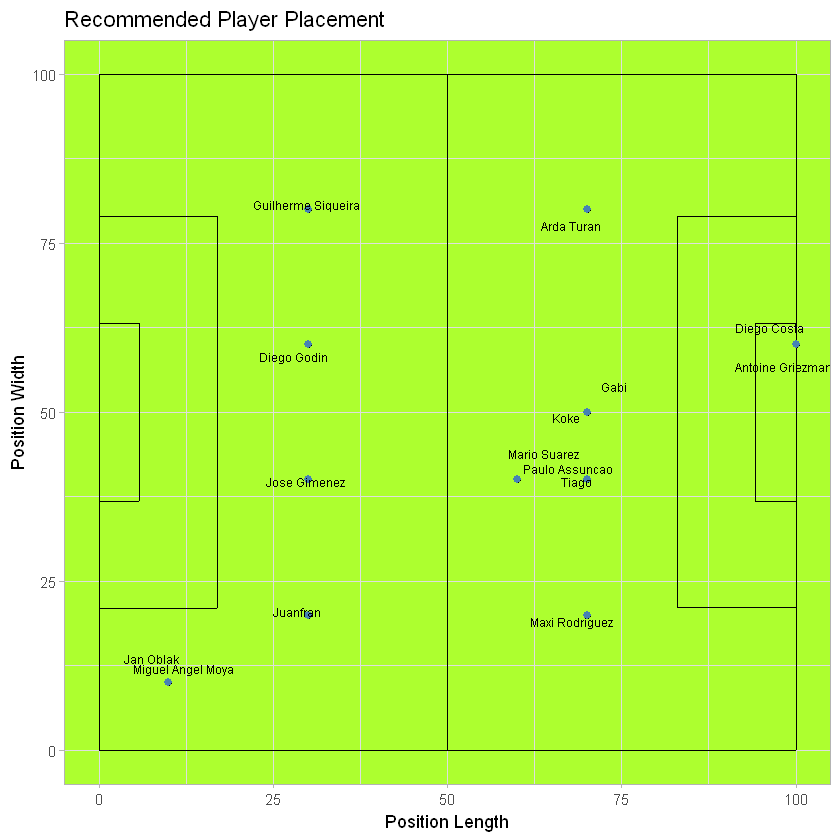

In [65]:
# The recommended field placement can be represented as follows                                    
loc <- loc %>% group_by(Player) %>% summarise(X.Location = mean(X.Location), Y.Location = mean(Y.Location))

ggplot(loc, aes(Y.Location * 10,X.Location * 10, label = Player)) + geom_point() + geom_segment(aes(x = 0, y = 0, xend = 0, yend = 100)) + geom_segment(aes(x = 100, y = 0, xend = 100, yend = 100)) + geom_segment(aes(x = 0, y = 0, xend = 100, yend = 0)) + geom_segment(aes(x = 0, y = 100, xend = 100, yend = 100)) + geom_segment(aes(x=50, y= 0, xend = 50, yend = 100)) + geom_segment(aes(x=0, y=21, xend = 17, yend=21)) + geom_segment(aes(x=17, y=21, xend = 17, yend=79)) + geom_segment(aes(x=0, y=79, xend = 17, yend= 79)) + geom_segment(aes(x=50, y= 0, xend = 50, yend = 100)) + geom_segment(aes(x=5.8, y= 36.8, xend = 0, yend = 36.8)) + geom_segment(aes(x=0, y=63.2, xend = 5.8, yend = 63.2)) + geom_segment(aes(x=5.8, y=36.8, xend = 5.8, yend = 63.2))+ geom_segment(aes(x=83, y=21.2, xend=100, yend=21.2)) + geom_segment(aes(x=83, y=21, xend=83, yend=79)) + geom_segment(aes(x=83, y=79, xend=100, yend=79))+ geom_segment(aes(x=100, y=36.8, xend=94.2, yend=36.8)) + geom_segment(aes(x=94.2, y=36.8, xend=94.2, yend=63.2)) + geom_segment(aes(x=100, y= 63.2, xend=94.2, yend=63.2)) + geom_point(size = 2, color = 'steelblue') +
  theme_light() +
  xlab('Position Length') +
  ylab('Position Width') +
  ggtitle('Recommended Player Placement') +
  theme(panel.background = element_rect(fill = 'greenyellow')) +
  geom_text(size = 2.5, position = 'jitter')
  

<h4><i>Interpretation of approach 2</i></h4>
We have used association mining to find player combinations that lead to win/loss. For any crucial match, the winning player combinations should be included while losing player combinations should be avoided. We have also found out player position combinations that more likely to result in wins

<h4><i>Conclusion from approach 2</i></h4>

To increase chances of wins, include the following player combinations:

1. Gabi, Lucas Hernandez
2. Fernando Torres,Yannick Ferreira-Carrasco
3. Gabi, Jan Oblak, Lucas Hernandez

To decrease chances of losing, avoid the following player combinations:

1. Diego Godin, Filipe Luis, Paulo Assuncao
2. Alvaro Dominguez, David De Gea, Juan Valera
3. Alvaro Dominguez,Jose Manual Jurado,Tiago

The followinng player positions (X-Y coordinates) result in high chances of wins:
Filipe Luis -> 8_3
Juanfran -> 2_3
Koke -> 8_7
Diego Godin -> 6_3
Jose Gimenez -> 4_3
Gabi -> 4_7
Thibaut Courtois -> 1_1
Arda Turan -> 8_7
Jan Oblak -> 1_1
<h4><i>Potential drawbacks</i></h4>
1. All players who have been playing in the last 5 years have been considered. We havent removed players who have retired or injured.

2.Our player position recommendations have not considered other external parameters (Opposition team) to bank on these recommendations completely. 

<h4><i>Based on conclusions from Approach 2, explanation of Approach and Goals 3</i></h4>

Even though we have identified players that are performing well for our team, players are subject to unforeseen events like injury or replacement that can put our team in disadvantage. Hence, we want to determine undelying player attributes that could quantify selection of a new player if required.

<hr>
<h2>Approach 3: How to be player independent - Atrribute analysis</h2>
<h4><i>Explanation</i></h4>

There can be several events where we need to bring in a new player such as injury, replacement or a new player purchase. Hence, even though we have identified well performing composition from current team, it will be helpful to understand the underlying attributes of the players that result in the team composition. This will help us in quikly shortlisting and selecting the new players in a quantified way in such events.

<b>Key goal:</b>

Determine `player attributes` for successfull team composition for events of replacement

In [66]:

#Compute wins for each match and filter by home league
match_tbl_result <- match_tbl %>% mutate( status = if_else(home_team_goal>away_team_goal, 'home', if_else(home_team_goal<away_team_goal, 'away', 'draw'))) %>% filter(league_id == 21518)

#Latest date for which data is available for each player
player_date <- player_atts_tbl %>% group_by(player_api_id) %>% dplyr::summarise(date = max(date))

#Filtered Player attributes data frame to have latest player data for each player 
player_atts <- player_date %>% inner_join(player_atts_tbl, by=c("player_api_id", "date"))

#Remove 4 rows with missing data
player_atts <- player_atts[complete.cases(player_atts$overall_rating),]

#Convert height into numeric
player_tbl$height <- as.numeric(player_tbl$height)

#Convert birthdate to age in years
player_tbl$age <-  as.numeric(difftime(Sys.Date(),as.Date(player_tbl$birthday), unit="weeks")/52.25)


#Select columns for analysis
player_a <- select(player_atts, c("player_api_id", "overall_rating", "potential", "preferred_foot", "attacking_work_rate", "defensive_work_rate", "crossing", "finishing", "heading_accuracy", "short_passing", "volleys", "dribbling", "curve", "free_kick_accuracy", "long_passing", "ball_control", "acceleration", "sprint_speed", "agility", "reactions", "balance", "shot_power", "jumping", "stamina", "strength", "long_shots", "aggression", "interceptions", "positioning", "vision", "penalties", "marking", "standing_tackle", "sliding_tackle"))

#Bin numeric data and prefix all data points with column names
#Renaming data poits makes it easier to interpret association rules later
for (col in names(player_a)) {
  if(typeof(player_a[[col]])=="integer")
  {
    if(col!="player_api_id") {
      player_a[[col]] <- cut_number(player_a[[col]], 5, labels=c(paste(col,"lowest"), paste(col,"low"),paste(col,"middle"), paste(col, "high"), paste(col,"highest")))
    }
  }else
  { 
    player_a[[col]] <- paste(col, player_a[[col]], sep='_')
  }

}


#######################################################################################################
#Filtered by players in winning matches

#Players who won at home
match_tbl_player_home <- match_tbl_result %>% filter(status == "home") %>% select(status, home_player_1 : home_player_11) %>% gather(key, value, -status) %>% filter(!is.na(value)) 

#Players who lost at home
match_tbl_player_home_loss <- match_tbl_result %>% filter(status != "home") %>% select(status, home_player_1 : home_player_11)  %>% gather(key, value, -status) %>% filter(!is.na(value)) 

#Players who won when away
match_tbl_player_away <- match_tbl_result %>% filter(status == "away") %>% select(status, away_player_1 : away_player_11) %>% gather(key, value, -status) %>% filter(!is.na(value))

#Players who lost when away
match_tbl_player_away_loss <- match_tbl_result %>% filter(status != "away") %>% select(status, away_player_1 : away_player_11) %>% gather(key, value, -status) %>% filter(!is.na(value))

#Players in winning teams
match_tbl_win_players <- rbind(match_tbl_player_home, match_tbl_player_away) %>% mutate(result='W') %>% select(value, result)

#Players in loosing teams
match_tbl_lost_players <- rbind(match_tbl_player_home_loss, match_tbl_player_away_loss) %>% mutate(result='L') %>% select(value, result)

#Joining player's wins and losses with player attributes for analysis 
player_win <- inner_join(player_a, match_tbl_win_players,c("player_api_id"="value"))
player_loss <- inner_join(player_a, match_tbl_lost_players,c("player_api_id"="value"))
player_win<- rbind(player_win, player_loss)

#Formating data to run Market Basket Analysis
player_gathered_win <- gather(player_win, key, value, -player_api_id )
player_pivoted <- ddply(player_gathered_win,c("player_api_id"),
                        function(player_gathered)paste(player_gathered$value,collapse = ","))
player_pivoted$player_api_id <- NULL
colnames(player_pivoted) <- c("items")
write.csv(player_pivoted,"player_attr.csv",  quote = FALSE, row.names = TRUE)
txn = read.transactions(file="player_attr.csv", rm.duplicates= TRUE, format="basket",sep=",",cols=1);
txn@itemInfo$labels <- gsub("\"","",txn@itemInfo$labels)
basket_rules <- apriori(txn ,parameter = list(sup = 0.2, conf = 0.4,maxlen=40,target="rules"))
                        
# Subsetting the rules for high frequency loss cases
basket_rules <- subset(basket_rules, subset = rhs %pin% "W")
inspect(sort(basket_rules, by='lift')[1:9])


#####
#Pick players who have high overall raing, potential, reaction and ball control attributes. 
#When it comes to foot preference, players preferring right foot lead to more wins
#Players with average defensive work rate also lead to wins. 


distribution of transactions with duplicates:
items
   6   33   34   40   67   68   74  101  102  135  136  141  169  170  176  203 
   2   21   33    2   18   20    1   24   12   33    9    2   26   10    1   20 
 204  209  237  238  243  271  272  277  305  306  339  345  373  407  408  413 
   3    2   24    5    1   19    1    1   26    1   18    1   30   22    1    1 
 441  475  509  510  543  549  577  583  611  617  645  651  679  680  713  747 
  19   17   28    1   23    1   22    1   20    1   19    1   18    1   12   22 
 781  815  821  849  883  917  951  957  985 1019 1053 1059 1087 1121 1155 1189 
  17   18    1   18    7   22   17    2   17   19   14    1   17   18   10    7 
1195 1223 1257 1263 1291 1325 1359 1393 1427 1461 1495 1529 1563 1597 1631 1665 
   2   17   13    1   14    4   13   10   15   10    7   12    6    8    4    8 
1699 1733 1767 1801 1835 1869 1903 1937 1971 2005 2039 2073 2107 2141 2175 2209 
  13    4    7    7    5    7    7    7    6    7   13   

In [67]:
#Running analysis on Height, Weight & Age of players

#Filtering out player biographical data
player_a_hw <-  inner_join(player_atts, player_tbl, by="player_api_id")
player_a_hw =  select(player_a_hw, c( "player_api_id" ,"height", "weight", "age"))


#Data is heavily centered around the middle, hence using equal sized binning in later stage
#ggplot(player_a_hw, aes(x=weight))+geom_histogram()
#ggplot(player_a_hw, aes(x=height))+geom_histogram()
#ggplot(player_a_hw, aes(x=age))+geom_histogram()

#Creating equal sized bins for height, weight and birthday
for (col in names(player_a_hw)) {
  if(col!="player_api_id") {
    player_a_hw[[col]] <- cut_number(player_a_hw[[col]], 5, labels=c(paste(col,"lowest"), paste(col,"low"),paste(col,"middle"), paste(col, "high"), paste(col,"highest")))
  }
}


#Formatting data for Masket Basket Analysis
player_win <- inner_join(player_a_hw, match_tbl_win_players,c("player_api_id"="value"))
player_loss <- inner_join(player_a_hw, match_tbl_lost_players,c("player_api_id"="value"))
player_win_loss_hw<- rbind(player_win, player_loss)
player_gathered_win_loss_hw <- gather(player_win_loss_hw, key, value, -player_api_id )
player_pivoted <- ddply(player_gathered_win_loss_hw,c("player_api_id"), 
                        function(player_gathered)paste(player_gathered$value,collapse = ","))
player_pivoted$player_api_id <- NULL
colnames(player_pivoted) <- c("items")
write.csv(player_pivoted,"player_attr.csv",  quote = FALSE, row.names = TRUE)

txn = read.transactions(file="player_attr.csv", rm.duplicates= TRUE, format="basket",sep=",",cols=1);

txn@itemInfo$labels <- gsub("\"","",txn@itemInfo$labels)
basket_rules <- apriori(txn ,parameter = list(sup = 0.05, conf = 0.5,target="rules"))                                         
basket_rules <- subset(basket_rules, subset = rhs %pin% "W")
inspect(sort(basket_rules, by='lift')[1:9])



#Using equal width lenght bins is skewing the result so we used equal sized bins


distribution of transactions with duplicates:
items
   3    4    7    8   11   12   15   16   19   20   23   24   27   28   31   32 
  21   35   18   21   24   12   35    9   26   11   22    3   25    5   20    1 
  35   36   39   43   47   48   51   55   59   60   63   67   71   75   79   80 
  26    1   19   30   23    1   19   17   28    1   24   23   21   20   18    1 
  83   87   91   95   99  103  107  111  115  119  123  127  131  135  139  143 
  12   22   17   19   18    7   22   19   17   19   15   17   18   10    9   17 
 147  151  155  159  163  167  171  175  179  183  187  191  195  199  203  207 
  14   14    4   13   10   15   10    7   12    6    8    4    8   13    4    7 
 211  215  219  223  227  231  235  239  243  247  251  255  259  263  267  271 
   7    5    7    7    7    6    7   13    4    1    8    5    6    7    5    8 
 275  279  283  287  291  295  299  303  307  311  315  319  323  327  331  335 
   3    5    3    6    8    7    9    4    4    3    5   

<h4><i>Interpretation of approach 3</i></h4>

From the market basket analysis of player attributes, there are more chances of winning if we have players with high: overall rating, potential, reaction and ball control attributes. Players with average defensive work rate also lead to wins. When it comes to foot preference, players preferring right foot lead to more wins.

From the market basket analysis of player's height, weight and age above, Players around and above the average weight, that is in the range of 168 to 178 pounds increase the chances of winning. Older players don't harm a team's chances of winning. Height surprisingly doesn't have any strong influence on winning chances.


<h4><i>Conclusion from approach 3</i></h4>

When picking new players or looking to backfill players, the team should prefer players with following attributes :
* Higher the following attributes the better
    * Overall Rating
    * Potential
    * Reaction
    * Ball Control
* Average defensive working rate
* Players with weight around or above average, which is around 168 to 178 pounds


<h4><i>Potential drawbacks</i></h4>
There can always be players who are exceptionally talented and these insights would not generalize to all soccer players. The coach and management should subjectively evaluate each player and rely on these insights for reference.

<h4><i>Based on conclusions from Approach 3, explanation of Approach and Goals 4</i></h4>

Despite selection of a team with good attributes, there can be certain opposition teams that might be difficult to tackle. Hence, we need to identify such opponants to come up with fresh strategy for them.

<hr>
<h2>Approach 4: Understanding opponents</h2>
<h4><i>Explanation</i></h4>

Even though we try to incorporate best attributes in our team composition, there can be certain opponants against whom our team is not giving a good performance. In such cases we might need to go back and think of a fresh game strategy. However, in order to achieve this, we need to be cognizant of the strength of opposition that outperform us.

<b>Key goal:</b>

Understand opposition strengths performing well against us consistently to device better strategy against them


Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.1    0.1    1 none FALSE            TRUE       5   0.025      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 7 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[1692 item(s), 304 transaction(s)] done [0.00s].
sorting and recoding items ... [63 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [156 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
     lhs                             rhs              support confidence     lift
[1]  {}                           => {status Loss} 0.25657895  0.2565789 1.000000
[2]  {P 3 Gerard Pique}           => {status Loss} 0.02631579  0.8000000 3.117949
[3]  {P 3 Pepe}                   => {s

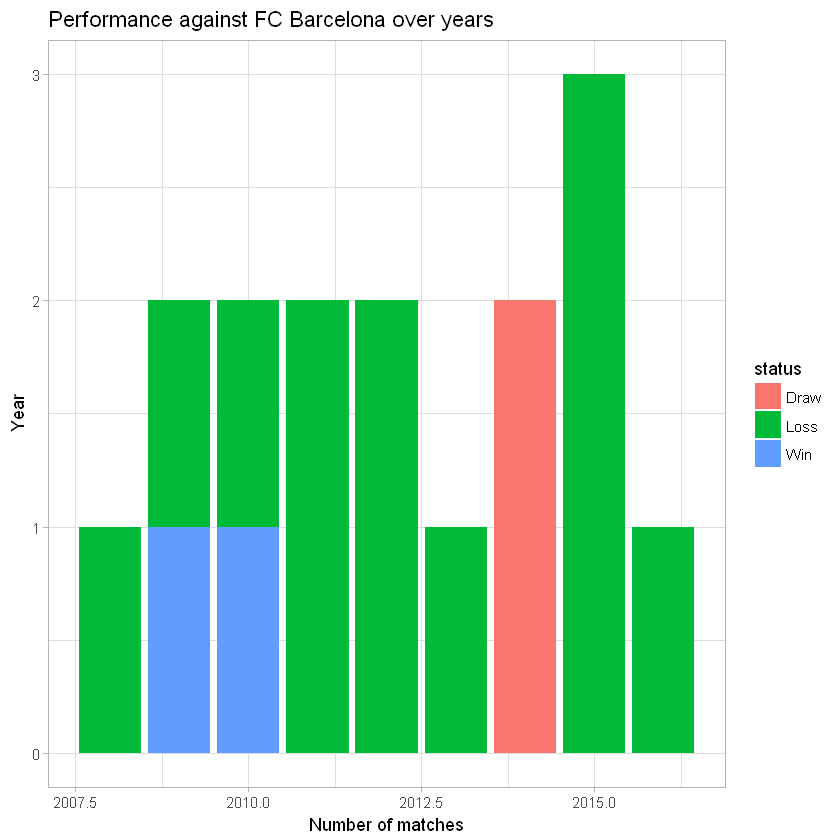

In [68]:
# Selecting team under consideration
my_team = 9906

# Setting up win loss conditions and understanding out team position
matches <- data.frame(match_tbl)
matches <- data.table(matches)
matches <- matches[home_team_api_id == my_team | away_team_api_id == my_team]
matches$my_loc <- ifelse(matches$home_team_api_id == my_team, 'H', 'A')
matches$status <- ifelse(matches$home_team_goal == matches$away_team_goal, 'Draw',
                         ifelse((matches$my_loc == 'H' & matches$home_team_goal > matches$away_team_goal) |
                                  (matches$my_loc == 'A' & matches$home_team_goal < matches$away_team_goal), 'Win', 'Loss'))

# Getting required tables and subsettig required columns
player_details <- data.frame(player_tbl)
team_details <- data.frame(team_tbl)
player_details <- player_details[, c('player_api_id', 'player_name')]
team_details <- team_details[, c('team_api_id', 'team_long_name')]

# Preparing final transaction table of opposition team and players
final_data <- select(matches, match_api_id, home_team_api_id, away_team_api_id, home_player_1:home_player_11, away_player_1:away_player_11, my_loc, status, date)
opp_H <- final_data[my_loc == 'A']
opp_A <- final_data[my_loc == 'H']
opp_H <- opp_H %>% select(match_api_id, home_team_api_id, home_player_1:home_player_11, status, date)
opp_A <- opp_A %>% select(match_api_id, away_team_api_id, away_player_1:away_player_11, status, date)
colnames(opp_A) <- c('match_api_id', 'team_api_id', paste('P', c(1:11)), "status", 'date')
colnames(opp_H) <- c('match_api_id', 'team_api_id', paste('P', c(1:11)), "status", 'date')
final_data <- rbind(opp_H, opp_A)
final_data$team_api_id <- team_details$team_long_name[match(final_data$team_api_id, team_details$team_api_id)]
final_data[, c(3:13)] <- lapply(final_data[, c(3:13)], function(x){return(player_details$player_name[match(x, player_details$player_api_id)])})

check <- final_data[team_api_id == 'FC Barcelona']
check$ins <- 1
check <- check %>% select(date, status, ins)
check$Year <- as.numeric(substr(check$date, 1, 4))
check <- check %>% group_by(Year, status) %>% summarise(tot = sum(ins))
ggplot(check, aes(x = Year, y = tot, fill = status)) +
  geom_bar(stat = "identity") +
  expand_limits(y = 0) +
  xlab('Number of matches') +
  ylab('Year') +
  theme_light() +
  ggtitle('Performance against FC Barcelona over years')

final_data$date <- NULL

final_data <- final_data %>% gather(Field, Value, - match_api_id)
final_data$Value <- paste(final_data$Field, final_data$Value, sep = ' ')
final_data$Field <- NULL
transactions <- as(split(final_data$Value, final_data$match_api_id), 'transactions')

# Association rule mining
rules <- apriori(transactions, parameter = list(supp = 0.025, conf = 0.1))

# Subsetting the rules for high frequency loss cases
rules <- subset(rules, subset = rhs %pin% "status L")
inspect(rules)


<h4><i>Interpretation of approach 4</i></h4>


There are a high number of rules which suggest highly inefeffective performance against Barcelona. We can argue that FC Barcelona is one of the best teams however, the number of rules with comparable teams such as Real Madrid are relatively less.
On observing the statistics related to these association rules we can comment:
1. The support for the rules is on average 2.5%. Even though the support is low, it could be attributed to relatively leser number of matches among same pair teams
2. All the rules show high confidenec in the range of 70%-80% which can help us to safely dedce a causal relationship
3. The lift observed is significantly high (more than 2.5 in most cases) suggesting that the probability of the cooccurence of these events purely by chance is low

<h4><i>Conclusion from approach 4</i></h4>

Atletico Madrid requires a fresh strategy against:
1. FC Barcelona
2. Teams with players with attributes comparable with
    1. Sergio Busquets
    2. Andres Iniesta
    3. Iker Casillas

<h4><i>Potential drawbacks</i></h4>

1. It is evident that the team we are losing against is one of the top performing team overall hence chances of succeeding with a revised strategy are relatively low
2. It is possible that the soft benefits from the identified players are driving the victory and replicating their quantified attributes might not guarantee a good counter-strategy


<h4><i>Based on conclusions from Approach 4, explanation of Approach and Goals 5</i></h4>

So far we have identified latent patterns that can be incorporated for a winning stategy `before` the game. As a next step, we would like to uncover patterns from the in-game events that lead to certain outomes for a runtime decision making.

<hr>
<h2>Approach 5: Event analysis for live decision making</h2>
<h4><i>Explanation</i></h4>

After understanding the patterns and factors that can be incorporated `pre-game` to enhance team performance, we now need to look at the `in-game` events that lead to a certain outcome for runtime decision making. For e.g. certain events such as a goal against our team in first half of the match when we have not scored could lead to reduced morale of the team leading to a loss. Hence it is important to identify such events for taking counter measures.

<b>Key goal:</b>
Identify patterns from `in-game events` that can enable on field decision making


In [69]:
# Selecting team under consideration
my_team = 9906

matches <- match_tbl %>% 
  filter(home_team_api_id == my_team | away_team_api_id == my_team)

# Adding the result column in the matches table
# W - Win
# L - Loss
# D - Draw
matches <- matches %>% collect() %>%
  mutate(result = home_team_goal - away_team_goal) %>%
  #filter(result > 0) %>%
  mutate(result = ifelse(result > 0, ifelse(home_team_api_id == 9906, "W", "L"), result)) %>%
  mutate(result = ifelse(result < 0, ifelse(home_team_api_id == 9906, "L", "W"), result)) %>%
  mutate(result = ifelse(result == 0, "D", result))

# Method to extract value from xpath
value_from_xpath  <- function(element, xpath, to.int = F, index = 1) {
  xml_find_all(element, xpath) %>%
  {ifelse(length(.), xml_text(.[[index]]), NA)} %>%
  {ifelse(to.int, as.integer(.), .)}
}

# Extract value from xml node to incident datagrame fields
node_to_dataframe <- function(n, key) {
  tibble_(list(
    id = ~value_from_xpath(n, './id', to.int = T),
    type = ~value_from_xpath(n, './type'),
    subtype1 = ~value_from_xpath(n, './subtype'),
    subtype2 = ~value_from_xpath(n, paste0('./', key, '_type')),
    player1 = ~value_from_xpath(n, './player1'),
    player2 = ~value_from_xpath(n, './player2'),
    team = ~value_from_xpath(n, './team'),
    lon = ~value_from_xpath(n, './coordinates/value', to.int = T, index = 1),
    lat = ~value_from_xpath(n, './coordinates/value', to.int = T, index = 2),
    elapsed = ~value_from_xpath(n, './elapsed', T),
    elapsed_plus = ~value_from_xpath(n, './elapsed_plus', T)
  ))
}

incidents <- read.csv("incidents.csv")
incidents <- tbl_df(incidents)
head(incidents %>% filter(!is.na(lon)))

X,id,type,subtype2,subtype1,player1,player2,team,lon,lat,elapsed,elapsed_plus,game_id,result
699,3897595,goal,deflected,n,184138,NA,9906,30,7,44,NA,23809,W
700,3897802,goal,header,n,301809,474680,7869,30,65,53,NA,23809,W
701,3897844,goal,header,n,184138,38424,9906,30,4,58,NA,23809,W
702,3897887,goal,header,n,75447,184533,9906,25,4,62,NA,23809,W
703,3898021,goal,header,n,33871,184533,9906,19,5,80,NA,23809,W
704,3898078,goal,shot,n,301809,NA,7869,26,64,87,NA,23809,W


In [70]:
# Binning the elapsed time into bins of 15 minutes 
# FirstHalf1 = 0 - 15 minutes
# FirstHalf2 = 16 - 30 minutes
# FirstHalf3 = 31 - 45 minutes (This also includes the extra time of first half)
# SecondHalf1 = 46 - 60 minutes
# SecondHalf2 = 61 - 75 minutes
# SecondHalf3 = 75 - 90 minutes (This also includes the extra time of second half)

goal_timing <- incidents %>% collect() %>%
  filter(type == "goal" & ifelse(is.na(subtype2), TRUE, !str_detect(subtype2, 'saved'))) %>%
  mutate(elapsed_bin = ifelse((elapsed > 0 & is.numeric(elapsed)), "FirstHalf1", elapsed)) %>%
  mutate(elapsed_bin = ifelse(elapsed > 15 & is.numeric(elapsed), "FirstHalf2", elapsed_bin)) %>%
  mutate(elapsed_bin = ifelse(elapsed > 30 & is.numeric(elapsed), "FirstHalf3", elapsed_bin)) %>%
  mutate(elapsed_bin = ifelse(elapsed > 45 & is.numeric(elapsed), "SecondHalf1", elapsed_bin)) %>%
  mutate(elapsed_bin = ifelse((elapsed > 60 & is.numeric(elapsed)), "SecondHalf2", elapsed_bin)) %>%
  mutate(elapsed_bin = ifelse(elapsed > 75 & is.numeric(elapsed), "SecondHalf3", elapsed_bin)) %>%
  mutate(team_goaltime = paste(elapsed_bin, ifelse(team == 9906, "Own", "Opp"), sep ="_"))

# Selecting the game id and result of the game
match_result <- goal_timing %>%
        select(game_id, v = result) %>%
        distinct

# Selecting the game id and goal timing
match_goal_timing <- goal_timing %>%
        select(game_id, v = team_goaltime)

# Performing market basket analysis
gt1 <- rbind(match_result, match_goal_timing)

pivoted_match <- ddply(gt1,c("game_id"), 
                       function(df1)paste(df1$v, 
                                          collapse = ","))

pivoted_match$game_id <- NULL
colnames(pivoted_match) <- c("items")
write.csv(pivoted_match,"items.csv",  quote = FALSE, row.names = TRUE)

txn = read.transactions(file="items.csv", rm.duplicates= TRUE, format="basket",sep=",",cols=1);

txn@itemInfo$labels <- gsub("\"","",txn@itemInfo$labels)

# Running the apriori algorithm with pinning the Win on the RHS                      
basket_rules_W <- apriori(txn ,parameter = list(sup = 0.1, conf = 0.1,target="rules"), appearance=list(rhs='W',default='lhs'))
inspect(basket_rules_W)

distribution of transactions with duplicates:
items
 1  2  3  4 
67  7  4  1 
Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.1    0.1    1 none FALSE            TRUE       5     0.1      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 28 

set item appearances ...[1 item(s)] done [0.00s].
set transactions ...[16 item(s), 285 transaction(s)] done [0.00s].
sorting and recoding items ... [15 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [8 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
    lhs                                  rhs support   confidence lift    
[1] {}                                => {W} 0.5859649 0.5859649  1.000000
[2] {FirstHalf1_Own}                  => {W} 0.1614035 0.67647

In [71]:
# Running the apriori algorithm with pinning the Loss on the RHS
basket_rules_L <- apriori(txn, parameter = list(sup = 0.1, conf = 0.1,target="rules"), appearance=list(rhs='L',default='lhs'))
inspect(basket_rules_L)

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.1    0.1    1 none FALSE            TRUE       5     0.1      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 28 

set item appearances ...[1 item(s)] done [0.00s].
set transactions ...[16 item(s), 285 transaction(s)] done [0.00s].
sorting and recoding items ... [15 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [3 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
    lhs                  rhs support   confidence lift    
[1] {}                => {L} 0.2736842 0.2736842  1.000000
[2] {FirstHalf1_Opp}  => {L} 0.1087719 0.6326531  2.311617
[3] {SecondHalf3_Opp} => {L} 0.1228070 0.4861111  1.776175


<h4><i>Interpretation of approach 5</i></h4>
We performed market basket analysis on the time when a goal is scored by our team as, and how would that result in a win.

After performing market basket analysis, we found that our team loses whenever opposition team scores a goal in the first 15 minutes, there is a confidence of 63.26%, along with a lift of 2.31.

Another rule, whenever our team scores a goal at the start of the second half of the game, there is a 91% confidence that our team wins, along with a lift of 1.56.

<h4><i>Conclusion from approach 5</i></h4>
This can be instrumental in deciding the strategy of the team and can be presented to the team, the manager and the coach. 

One of the strategy can be that our team can be in a defensive position at the start of the game, and then transition to a more attacking position as the game progress after the first half.


<h4><i>Potential drawbacks</i></h4>
Although, these rules provide a high confidence, but outcome might be against some set of teams.


<hr>
<h2>Conclusions & Recomendations</h2>

1. Improve the overall team performance by designing training program for identified attributes
2. Leverage top performing players for better chances of winning while avoiding poor performing combinations
3. Utilize underlying player attributes for cherry-picking new players for replacements and purchases
4. Make run time decision to maximize chances of winning based on in-game events
